In [1]:
import os
import pandas as pd
import numpy as np
from pandasgui import show


# Definir la ruta a la carpeta de datos
ruta = os.path.join('..', 'data')

# Definir los años para los que hay archivos
years = range(2019, 2024)

# Crear un diccionario vacío para almacenar los dataframes
dfs = {}

# Leer los archivos CSV y almacenarlos en el diccionario
for year in years:
    file_path = os.path.join(ruta, f'{year}clean.csv')  # crea la ruta al archivo
    dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario

# Agregar una columna de año a cada dataframe
for year, df in dfs.items():
    df['año'] = int(year[2:])

# Crear una lista de dataframes
dfs_list = [df for df in dfs.values()]

# Concatenar todos los dataframes
contratos_df = pd.concat(dfs_list, ignore_index=True)


This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_41084/1207649852.py:19: DtypeWarning: Columns (6,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_41084/1207649852.py:19: DtypeWarning: Columns (6,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_41084/1207649852.py:19: DtypeWarning: Columns (6,7,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folder

In [2]:

def correct_swap(df):
    # Define un patrón de RFC válido
    rfc_pattern = r"^[A-ZÑ&]{3,4}[0-9]{2}(0[1-9]|1[0-2])(0[1-9]|1[0-9]|2[0-9]|3[0-1])[A-Z0-9]?[A-Z0-9]?[0-9A]$"

    # Rellena los NaN con una cadena vacía para poder aplicar str.match
    df.fillna("", inplace=True)

    # Identifica las filas donde 'rfc' no es un RFC válido y 'proveedor_o_contratista' es un RFC válido
    mask_invalid = ~df['rfc'].str.match(rfc_pattern) & df['proveedor_o_contratista'].str.match(rfc_pattern)

    # Intercambia 'rfc' y 'proveedor_o_contratista' para las filas identificadas
    df.loc[mask_invalid, 'rfc'], df.loc[mask_invalid, 'proveedor_o_contratista'] = df.loc[mask_invalid, 'proveedor_o_contratista'], df.loc[mask_invalid, 'rfc']

    # Identifica las filas donde 'rfc' no es un RFC válido y 'proveedor_o_contratista' es una cadena vacía
    mask_invalid_empty = ~df['rfc'].str.match(rfc_pattern) & (df['proveedor_o_contratista'] == "")

    # Intercambia 'rfc' y 'proveedor_o_contratista' para las filas identificadas y asigna un valor artificial a 'rfc'
    df.loc[mask_invalid_empty, 'rfc'], df.loc[mask_invalid_empty, 'proveedor_o_contratista'] = 'XAXX010101000', df.loc[mask_invalid_empty, 'rfc']

    # Reemplaza las cadenas vacías con NaN de nuevo
    df.replace("", np.nan, inplace=True)

    return df

# Supón que contratos_df es tu DataFrame original
contratos_df = correct_swap(contratos_df)


In [3]:
def verify_correction(df):
    # Identificar filas donde rfc tiene una longitud distinta a 13
    mask = df['rfc'].str.len() != 12
    # Retornar filas donde rfc tiene una longitud distinta a 13
    return df.loc[mask]

verify_correction(contratos_df[['rfc', 'proveedor_o_contratista']])

,rfc,proveedor_o_contratista
3,XAXX010101000,JAIME DAVID BRANDON GRACIDA
4,XAXX010101000,JAIME DAVID BRANDON GRACIDA
11,XAXX010101000,"EDIFICADORA DOPERZ, S.A. DE C.V."
15,XAXX010101000,LUIS ALBERTO MIRAMONTES CARDENAS
56,XAXX010101000,"EVOLUCIONA COMUNICACIONES, EVOX, S.A DE C.V."
...,...,...
735599,XAXX010101000,ALEXIA ANAEL AVILA SOLIS
735606,XAXX010101000,MARTIN ORTIZ VALDEZ
735616,XAXX010101000,JOSE DE JESUS DIAZ CORONA
735619,XAXX010101000,TOMAS ESPINOZA BENAVIDES


In [4]:
import pandas as pd
from currency_converter import CurrencyConverter


contratos_df['importe_del_contrato'] = contratos_df['importe_del_contrato']\
    .replace('[\$,]', '', regex=True)\
    .astype(float)

# Crear una instancia del convertidor de moneda
c = CurrencyConverter()
currencies = ['USD', 'CAD', 'EUR', 'GBP', 'JPY']

# Crear un diccionario para almacenar las tasas de conversión
conversion_rates = {}

for m in currencies:
    conversion_rate = c.convert(1, m, 'MXN')
    print(1, m, "=", conversion_rate, 'MXN')
    conversion_rates[m] = conversion_rate

# Crear una nueva columna para el importe convertido
contratos_df["importe"] = contratos_df["importe_del_contrato"]

# Aplicar las tasas de conversión
for currency, conversion_rate in conversion_rates.items():
    contratos_df.loc[contratos_df['moneda_del_contrato'] == currency, 'importe'] = \
        contratos_df.loc[contratos_df['moneda_del_contrato'] == currency, "importe_del_contrato"] * conversion_rate

print('Conversión completada')


<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_41084/1206435380.py:6: SyntaxWarning: invalid escape sequence '\$'
  .replace('[\$,]', '', regex=True)\


1 USD = 17.521694311685877 MXN
1 CAD = 12.709808986472705 MXN
1 EUR = 18.6974 MXN
1 GBP = 21.487559616158133 MXN
1 JPY = 0.11615456296204262 MXN
Conversión completada


In [5]:
contratos_df['siglas_de_la_institucion'].unique()

array(['COAH', 'OAX', 'MEX', 'IMSS', 'BIENESTAR', 'NOTIMEX', 'LICONSA',
       'HJM', 'SSA', 'INDAABIN', 'IPICYT', 'INAPESCA', 'ASA', 'HIM', 'NL',
       'CMM', 'CRAE', 'FONHAPO', 'FGR', 'CONALITEG', 'HGM', 'ININ',
       'CIQA', 'SADER', 'CONAGUA', 'CONUEE', 'ISSSTE', 'INEA', 'CONAFOR',
       'CAPUFE', 'IMT', 'CONAFE', 'HRAEO', 'PROFEPA', 'AGN', 'TFJA',
       'DICONSA', 'SEMARNAT', 'SICT', 'INMEGEN', 'POI', 'TELECOMM',
       'CINVESTAV', 'CNBBBJ', 'PR', 'INDESOL', 'RAN', 'AGS', 'INALI',
       'API-Coatzacoalcos', 'CULTURA', 'INEGI', 'GTO', 'YUC', 'SEDENA',
       'SON', 'PUE', 'CENAM', 'CHIH', 'TAMPS', 'CIAD', 'DGO', 'VER', 'BC',
       'CIATEQ', 'SAP', 'IFT', 'COFECE', 'COLPOS', 'INAOE', 'CIDETEQ',
       'HGO', 'INEEL', 'SLP', 'HRAEB', 'TAB', 'ECOSUR', 'NAY', 'CNTS',
       'TLAX', 'HRAEI', 'ZAC', 'QROO', 'HG', 'BCS', 'MICH', 'INNN', 'FIT',
       'INAI', 'COL', 'COMIMSA', 'CONDUSEF', 'CAMP', 'SEGOB', 'HRAEV',
       'SIN', 'API-Salina Cruz', 'BANJERCITO', 'SE', 'FIFOMI', 'CONEV

### Función de búsqueda

In [6]:
import re

# Función de filtrado
def filter_contratos(contratos_df):
    # Solicita al usuario un proveedor o contratista o RFC
    search_term = input("Por favor, ingresa el nombre del proveedor o contratista o el RFC (déjalo en blanco para mostrar todos): ").upper()

    # Solicita al usuario las siglas de la institución o "todas" para buscar en todas
    institution_input = input("Por favor, ingresa las siglas de las instituciones separadas por comas (déjalo en blanco para mostrar todas) o 'todas' para buscar en todas: ").upper()

    # Solicita al usuario las palabras clave en la descripción del contrato
    keywords = input("Por favor, ingresa las palabras clave en la descripción del contrato (separa múltiples palabras con comas, déjalo en blanco para buscar todas): ").upper()

    # Solicita al usuario las palabras a excluir en la descripción del contrato
    exclude_words = input("Por favor, ingresa las palabras a excluir en la descripción del contrato (separa múltiples palabras con comas, déjalo en blanco para no excluir ninguna): ").upper()

    # Solicita al usuario el año
    years_input = input("Por favor, ingresa el año (separa múltiples años con comas, déjalo en blanco para mostrar todos): ")

    # Inicialmente asumimos todos los contratos
    filtered_df = contratos_df.copy()

    # Filtra por proveedor o contratista o RFC si se proporciona
    if search_term:
        search_terms = [term.strip() for term in search_term.split(',')]
        search_conditions = [filtered_df['proveedor_o_contratista'].str.contains(term, case=False) | filtered_df['rfc'].str.contains(term, case=False) for term in search_terms]
        combined_search_condition = pd.concat(search_conditions, axis=1).any(axis=1)
        filtered_df = filtered_df.loc[combined_search_condition]

    # Filtra por institución si se proporciona
    if institution_input != 'TODAS' and institution_input:
        institutions = institution_input.split(',')
        filtered_df = filtered_df.loc[filtered_df['siglas_de_la_institucion'].isin(institutions)]

    # Filtra por año si se proporciona
    if years_input:
     years = [int(year.strip()) for year in years_input.split(',')]
     filtered_df = filtered_df.loc[filtered_df['año'].isin(years)]

    # Reemplaza los NaN en la descripción del contrato por cadenas vacías
    filtered_df['descripcion_del_contrato'] = filtered_df['descripcion_del_contrato'].fillna('')

    # Filtra por palabras clave en la descripción del contrato si se proporcionan
    if keywords:
        keywords = '|'.join(re.escape(keyword.strip()) for keyword in keywords.split(','))
        filtered_df = filtered_df.loc[filtered_df['descripcion_del_contrato'].str.contains(keywords, case=False)]

    # Excluye contratos que contienen ciertas palabras en la descripción del contrato si se proporcionan
    if exclude_words:
        exclude_words = '|'.join(re.escape(word.strip()) for word in exclude_words.split(','))
        filtered_df = filtered_df.loc[~filtered_df['descripcion_del_contrato'].str.contains(exclude_words, case=False)]

    # Ordena el DataFrame filtrado por importe en orden descendente
    filtered_df = filtered_df.sort_values(by='importe', ascending=False)

    # Muestra el DataFrame filtrado
    return filtered_df


# Búsqueda

In [11]:
# Usa la función:
buscar = filter_contratos(contratos_df)
#buscar[['tipo_de_procedimiento', 'siglas_de_la_institucion', 'titulo_del_contrato', 'descripcion_del_contrato','rfc','proveedor_o_contratista', 'importe', 'direccion_del_anuncio', 'año']]
#dp.DataTable(buscar[['tipo_de_procedimiento', 'siglas_de_la_institucion', 'titulo_del_contrato', 'descripcion_del_contrato','rfc','proveedor_o_contratista', 'importe', 'direccion_del_anuncio', 'año']])
show(buscar[['tipo_de_procedimiento', 'siglas_de_la_institucion', 'titulo_del_contrato', 'descripcion_del_contrato','rfc','proveedor_o_contratista', 'importe', 'direccion_del_anuncio', 'año']])

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


In [10]:
suma_por_año = buscar.groupby('año')['importe'].sum()
suma_por_año

año
2019    2248770.0
2022    1066920.0
Name: importe, dtype: float64

### Resultados de búsqueda por institución

In [11]:

pd.options.display.float_format = '{:,}'.format

ins_df=buscar.groupby(['siglas_de_la_institucion', 'institucion', 'proveedor_o_contratista', 'rfc']).agg({'importe':'sum'}).reset_index()

ins_df.sort_values(by='importe', ascending=False, inplace=True)
#institucion.set_index('Ins
# titución', inplace=True)

proveedor = ins_df['proveedor_o_contratista'].iloc[0]
ins_df

,siglas_de_la_institucion,institucion,proveedor_o_contratista,rfc,importe
1,CULTURA,Secretaría de Cultura,EDITORIAL PLANETA MEXICANA SA DE CV,EPM880422LV3,"2,248,770.0"
0,CONALITEG,Comisión Nacional de Libros de Texto Gratuitos,EDITORIAL PLANETA MEXICANA SA DE CV,EPM880422LV3,"1,066,920.0"


In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math

ins_df=buscar.groupby(['siglas_de_la_institucion', 'institucion']).agg({'importe':'sum'}).reset_index()
ins_df.sort_values(by='importe', ascending=False, inplace=True)

ins_df=ins_df.head(10)

instituciones = ins_df['siglas_de_la_institucion'].values
importe = ins_df['importe'].values / 1e3  # Convertimos a miles


In [36]:
# Determine the order of magnitude of the max value
magnitude = 10 ** (math.floor(math.log10(max(importe))))

# Adjust the interval based on the magnitude
if max(importe) / magnitude < 2.5:
    y_interval = 0.5 * magnitude
elif max(importe) / magnitude < 5:
    y_interval = magnitude
else:
    y_interval = 2 * magnitude


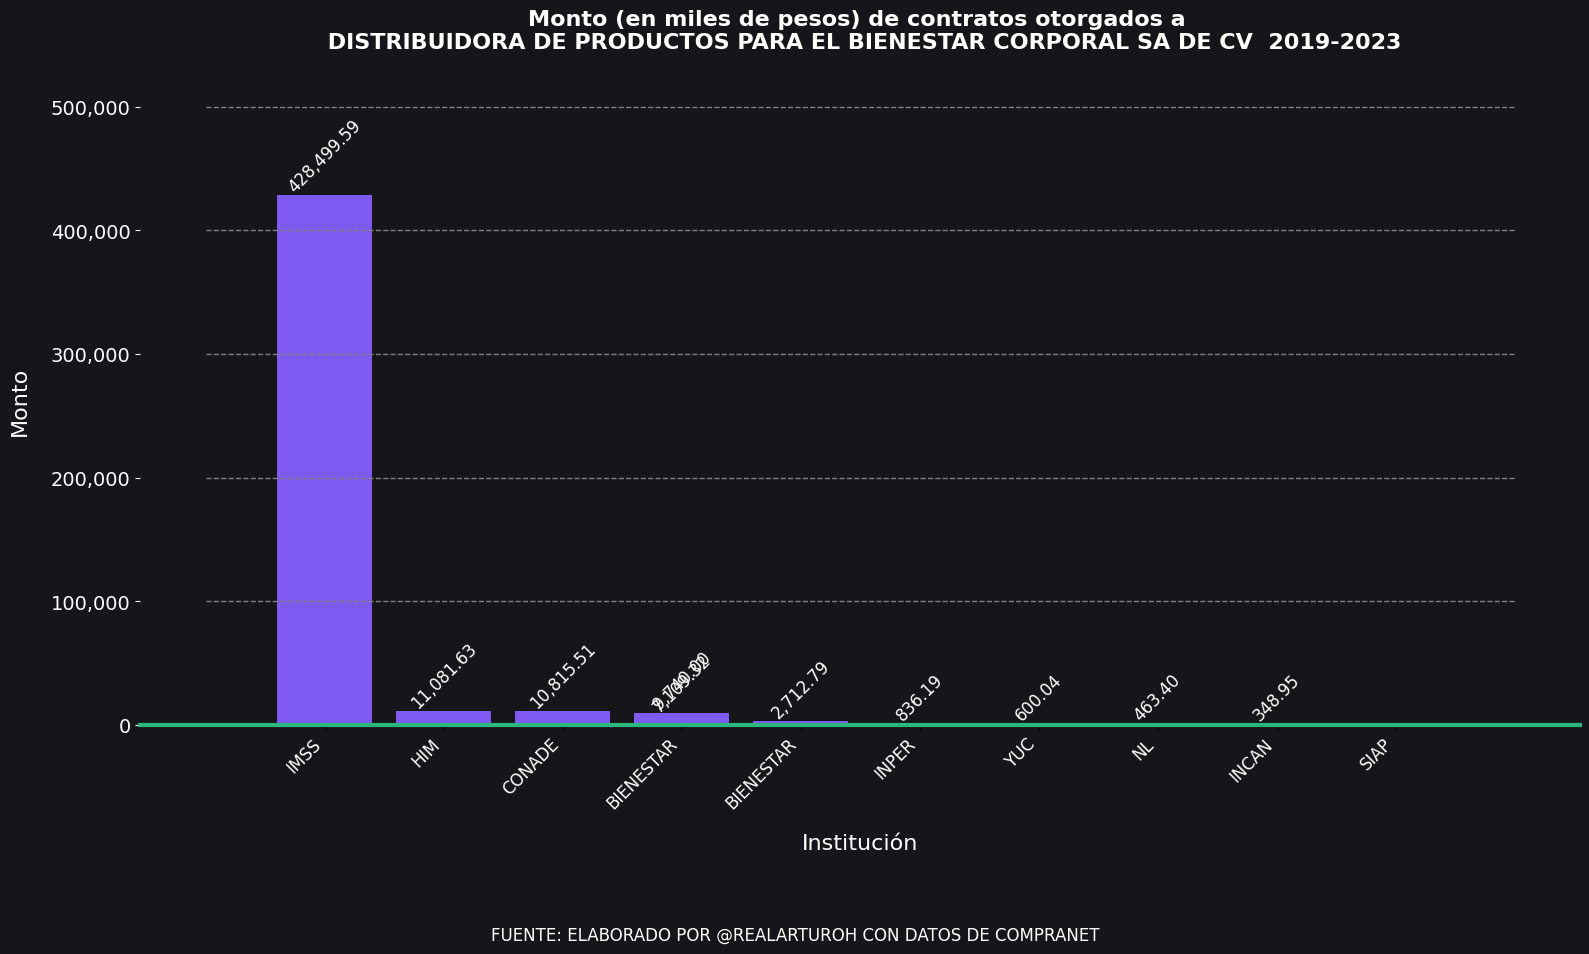

In [37]:
width = max(16, 0.5*len(instituciones))
height = width * (9/16)

fig, ax = plt.subplots(figsize=(width, height))
bars = ax.bar(instituciones, importe, color='#7f5af0')

ax.set_title(f"Monto (en miles de pesos) de contratos otorgados a \n {proveedor}  2019-2023", fontsize=16, pad=20, fontweight='bold', color='#fffffe')
ax.set_xlabel("Institución", fontsize=16, labelpad=15, color='#fffffe')
ax.set_ylabel("Monto", fontsize=16, labelpad=15, color='white')

ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(instituciones))))
ax.set_xticklabels(instituciones, fontsize=12, rotation=45, color='#fffffe', ha="right")

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='y', labelsize=14, colors='white')

ax.yaxis.set_major_locator(ticker.MultipleLocator(y_interval))
for y in np.arange(0, max(importe)+y_interval, y_interval):
    plt.hlines(y, xmin=-1, xmax=len(instituciones), colors='gray', linestyles='dashed', linewidth=1)

fig.set_facecolor('#16161a')
ax.set_facecolor('#16161a')

for spine in ['left', 'right', 'top']:
    ax.spines[spine].set_visible(False)

ax.spines['bottom'].set_linewidth(3)
ax.spines['bottom'].set_color('#2cb67d')

for bar in bars:
    yval = bar.get_height()
    formatted_yval = "{:,.2f}".format(yval)
    ax.text(bar.get_x() + bar.get_width()/2, yval+0.1, formatted_yval, ha='center', va='bottom', fontsize=12, color='#fffffe', rotation=45)

plt.figtext(0.5, -0.08, "FUENTE: ELABORADO POR @REALARTUROH CON DATOS DE COMPRANET", ha="center", fontsize=12, color='#fffffe')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

### Resultados de búsqueda por proveedor

In [38]:
# Asumiendo que 'buscar' es tu DataFrame original

# Creando el DataFrame prov_df con sumas de importes
prov_df = buscar.groupby(['proveedor_o_contratista', 'rfc']).agg({'importe':'sum'}).reset_index()
prov_df.sort_values(by='importe', ascending=False, inplace=True)

# Añadiendo la columna 'año_constitucion'
def convert_year(two_digit_year):
    if two_digit_year.isdigit():
        year_int = int(two_digit_year)
        if year_int > 23:
            return "19" + two_digit_year
        else:
            return "20" + two_digit_year
    else:
        return "unknown"

prov_df['año_constitucion'] = prov_df['rfc'].apply(lambda x: convert_year(str(x)[3:5]) if len(str(x)) >= 5 else "unknown")

# 1. Crear una tabla dinámica basada en el importe
pivot_df_importe = buscar.pivot_table(index='proveedor_o_contratista', columns='tipo_de_procedimiento', values='importe', aggfunc='sum', fill_value=0)

# 2. Convertir sumas en porcentajes
pivot_df_percentage = pivot_df_importe.divide(pivot_df_importe.sum(axis=1), axis=0) * 100
pivot_df_percentage.reset_index(inplace=True)

# 3. Fusionar con prov_df
prov_df = pd.merge(prov_df, pivot_df_percentage, on='proveedor_o_contratista', how='left')

# Opcional: mostrar el resultado
pd.options.display.float_format = '{:,}'.format

prov_df

,proveedor_o_contratista,rfc,importe,año_constitucion,ADJUDICACIÓN DIRECTA,CONTRATO ENTRE ENTES PUBLICOS,INVITACIÓN A CUANDO MENOS 3 PERSONAS,LICITACIÓN PÚBLICA
0,DISTRIBUIDORA DE PRODUCTOS PARA EL BIENESTAR C...,DPB0806309B2,"299,782,431.89",2008,99.65471290846696,0.0,0.26979911227645886,0.07548797925658192
1,PROMOTORA DE DESARROLLO Y BIENESTAR FAMILIAR AC,PDB140801M99,"76,709,350.0",2014,0.0,0.0,0.0,100.0
2,IMPULSORA PARA EL BIENESTAR Y EL DESARROLLO SC,IBD0403126K9,"19,993,515.0",2004,100.0,0.0,0.0,0.0
3,SUMINISTRADOR DE UTENCILIOS MEDICOS SALUD Y BI...,SUM101004FE1,"18,756,604.23",2010,73.93937192524803,0.0,9.189092404778055,16.871535669973916
4,ESTANCIA PARA EL BIENESTAR Y DESARROLLO INFANT...,XAXX010101000,"12,771,538.0",unknown,100.0,0.0,0.0,0.0
5,CASCADA BIENESTAR S A P I DE CV,CBI170127RDA,"10,815,512.870000001",2017,100.0,0.0,0.0,0.0
6,FINANCIERA PARA EL BIENESTAR,TME891117F56,"10,198,421.1",1989,0.0,100.0,0.0,0.0
7,ESTANCIA DE DESARROLLO Y BIENESTAR INFANTIL SC,EDB000913MKA,"9,439,065.0",2000,100.0,0.0,0.0,0.0
8,ALFER MEDICAMENTOS BIENESTAR Y SALUD SA DE CV,AMB180615TI8,"4,891,640.0",2018,100.0,0.0,0.0,0.0
9,TAM_BIENESTAR_SODEXO MOTIVATION SOLUTIONS MEXI...,XAXX010101000,"3,812,841.44",unknown,0.0,0.0,100.0,0.0


In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math

prov_df2 = prov_df
prov_df2.sort_values(by='importe', ascending=True, inplace=True)
prov_df2 = prov_df2.tail(20)

proveedores = prov_df2['proveedor_o_contratista'].values
importe = prov_df2['importe'].values / 1e3  # Convertimos a miles


In [28]:
# Determine the order of magnitude of the max value
magnitude = 10 ** (math.floor(math.log10(max(importe))))

# Adjust the interval based on the magnitude
if max(importe) / magnitude < 2.5:
    x_interval = 0.5 * magnitude
elif max(importe) / magnitude < 5:
    x_interval = magnitude
else:
    x_interval = 2 * magnitude


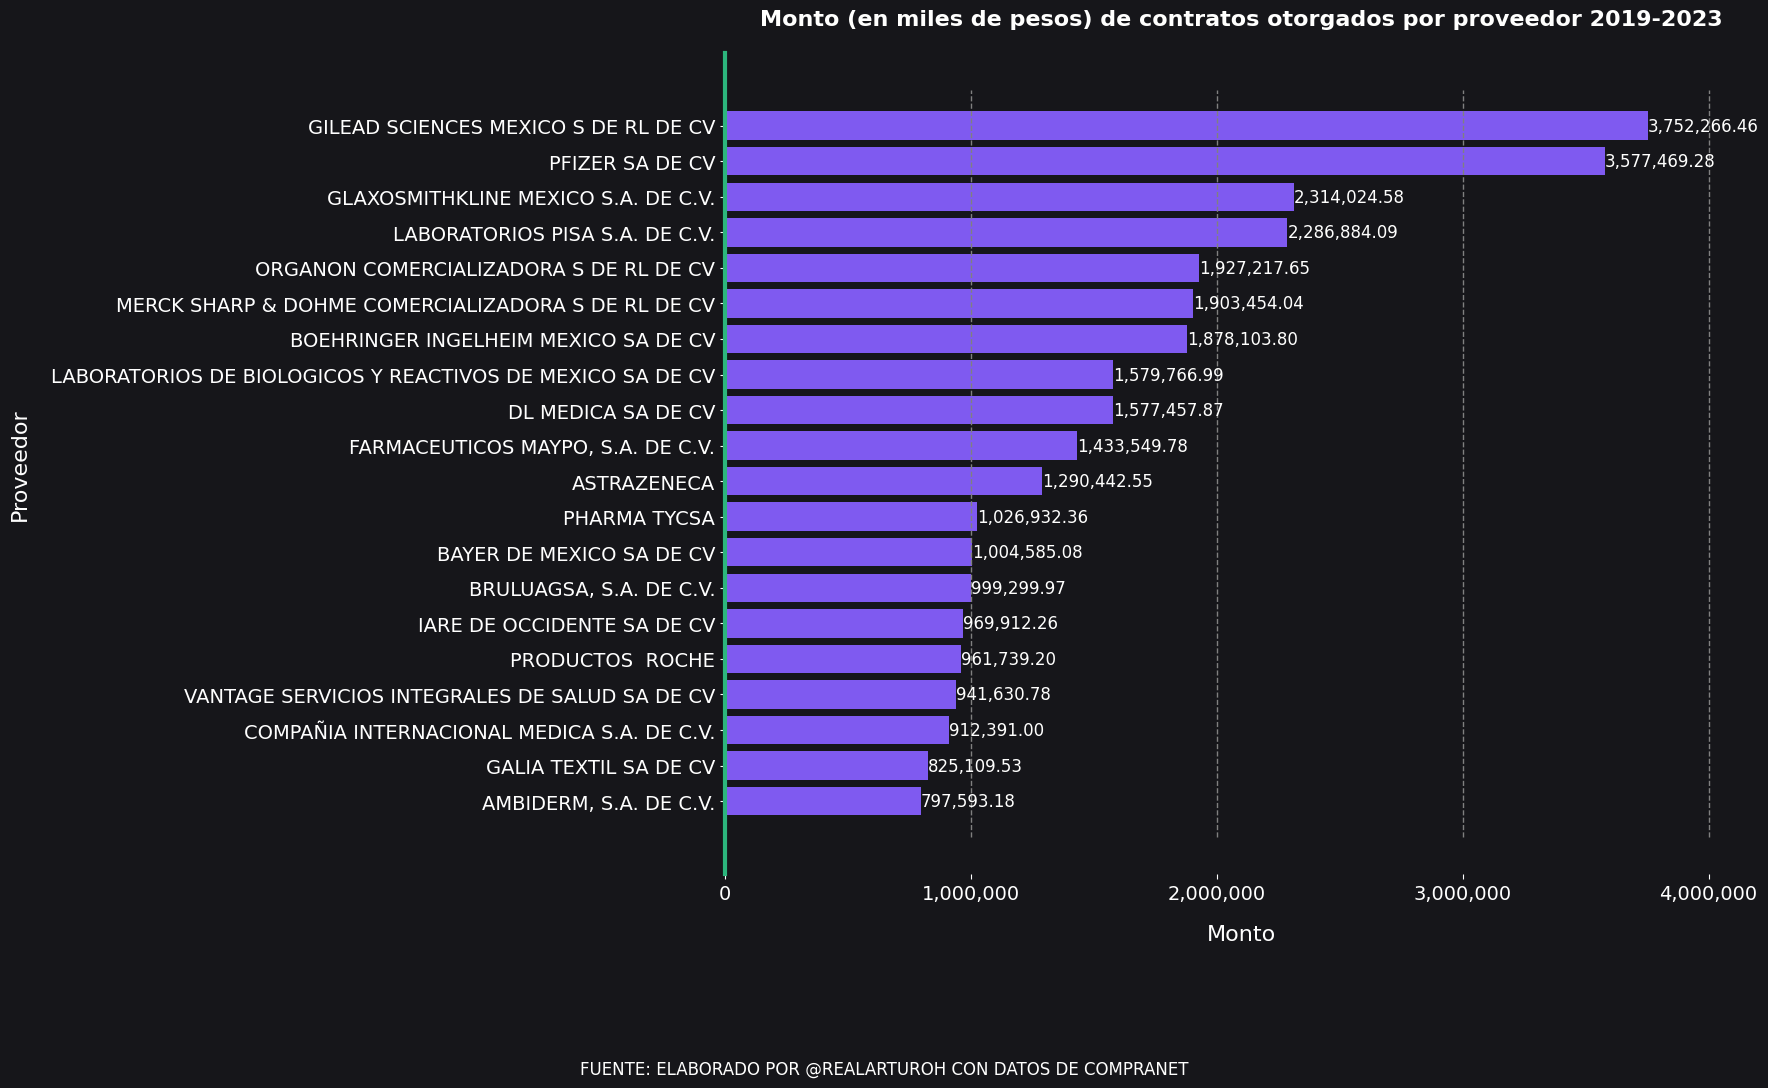

In [29]:
height = max(10, 0.5 * len(proveedores))
width = height * (16/9)

fig, ax = plt.subplots(figsize=(width, height))
bars = ax.barh(proveedores, importe, color='#7f5af0')

ax.set_title(f"Monto (en miles de pesos) de contratos otorgados por proveedor 2019-2023", fontsize=16, pad=20, fontweight='bold', color='#fffffe')
ax.set_ylabel("Proveedor", fontsize=16, labelpad=15, color='white')
ax.set_xlabel("Monto", fontsize=16, labelpad=15, color='white')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='x', labelsize=14, colors='white')

ax.xaxis.set_major_locator(ticker.MultipleLocator(x_interval))
for x in np.arange(0, max(importe)+x_interval, x_interval):
    plt.vlines(x, ymin=-1, ymax=len(proveedores), colors='gray', linestyles='dashed', linewidth=1)

fig.set_facecolor('#16161a')
ax.set_facecolor('#16161a')

for spine in ['bottom', 'right', 'top']:
    ax.spines[spine].set_visible(False)

ax.spines['left'].set_linewidth(3)
ax.spines['left'].set_color('#2cb67d')
ax.tick_params(axis='y', labelsize=14, colors='white')

for bar in bars:
    xval = bar.get_width()
    formatted_xval = "{:,.2f}".format(xval)
    ax.text(xval + 0.1, bar.get_y() + bar.get_height()/2, formatted_xval, ha='left', va='center', fontsize=12, color='#fffffe')

plt.figtext(0.5, -0.08, "FUENTE: ELABORADO POR @REALARTUROH CON DATOS DE COMPRANET", ha="center", fontsize=12, color='#fffffe')
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()

### Proveedores sospechosos


In [30]:
import datetime

# Año actual
current_year = datetime.datetime.now().year

# Función para calcular la probabilidad de sospecha
def calculate_suspicion(row):
    suspicion_score = 0

    # Si la empresa se constituyó en los últimos 5 años
    if row['año_constitucion'] != 'unknown' and (current_year - int(row['año_constitucion'])) <= 5:
        suspicion_score += 0.5

    # Obtener los valores para "ADJUDICACIÓN DIRECTA", "INVITACIÓN A CUANDO MENOS 3 PERSONAS", y "OTRO", o 0 si no existen
    adjudicacion_directa = row.get('ADJUDICACIÓN DIRECTA', 0)
    invitacion_tres_personas = row.get('INVITACIÓN A CUANDO MENOS 3 PERSONAS', 0)
    other_value = row.get('OTRO', 0)

    # Si más del 50% de su importe proviene de "ADJUDICACIÓN DIRECTA" o "INVITACIÓN A CUANDO MENOS 3 PERSONAS"
    if adjudicacion_directa + invitacion_tres_personas + other_value > 50:
        suspicion_score += 0.5

    return suspicion_score


# Aplicar la función para calcular la probabilidad de sospecha
prov_df['probabilidad_sospecha'] = prov_df.apply(calculate_suspicion, axis=1)

# Filtrar los proveedores sospechosos
suspicious_providers = prov_df[prov_df['probabilidad_sospecha'] >= 0.5]

# Seleccionar los 20 proveedores sospechosos que más han ganado
top_20_suspicious_providers_df = suspicious_providers.nlargest(20, 'importe')

# Resultado
top_20_suspicious_providers_df


,proveedor_o_contratista,rfc,importe,año_constitucion,ADJUDICACIÓN DIRECTA,CONTRATO ENTRE ENTES PUBLICOS,INVITACIÓN A CUANDO MENOS 3 PERSONAS,LICITACIÓN PÚBLICA,OTRAS CONTRATACIONES,Otro,probabilidad_sospecha
0,GILEAD SCIENCES MEXICO S DE RL DE CV,GSM1406097M7,"3,752,266,456.0",2014,100.0,0.0,0.0,0.0,0.0,0.0,0.5
1,PFIZER SA DE CV,PFI730206632,"3,577,469,277.03",1973,99.60746179162295,0.0,0.0,0.38639594855440446,0.0,0.006142259822653165,0.5
2,GLAXOSMITHKLINE MEXICO S.A. DE C.V.,GME970702SP5,"2,314,024,575.01",1997,99.81365518240537,0.0,0.0,0.18350276249567773,0.0,0.0028420550989479865,0.5
4,ORGANON COMERCIALIZADORA S DE RL DE CV,VCM1911309C9,"1,927,217,651.36",2019,79.3846872542011,0.0,0.0,0.0,0.0,20.615312745798906,1.0
5,MERCK SHARP & DOHME COMERCIALIZADORA S DE RL D...,MS&040819FJA,"1,903,454,042.07",2004,100.0,0.0,0.0,0.0,0.0,0.0,0.5
6,BOEHRINGER INGELHEIM MEXICO SA DE CV,BIM0711148Q0,"1,878,103,803.94",2007,100.0,0.0,0.0,0.0,0.0,0.0,0.5
7,LABORATORIOS DE BIOLOGICOS Y REACTIVOS DE MEXI...,LBR990311Q29,"1,579,766,990.99",1999,94.65585759836405,0.0,5.138242832017312,0.0,0.0,0.20589956961863093,0.5
8,DL MEDICA SA DE CV,DME971017FZ7,"1,577,457,872.1399999",1997,54.372467885540324,0.0,0.0,44.9179137185162,0.0,0.7096183959434912,0.5
9,"FARMACEUTICOS MAYPO, S.A. DE C.V.",FMA9301181B1,"1,433,549,776.01",1993,99.6442817730957,0.0,0.0,0.03830611788143839,0.0,0.31741210902285916,0.5
10,ASTRAZENECA,AST961231B69,"1,290,442,549.68",1996,98.38988329061831,0.0,0.0,1.585625079052006,0.0,0.024491630329678597,0.5


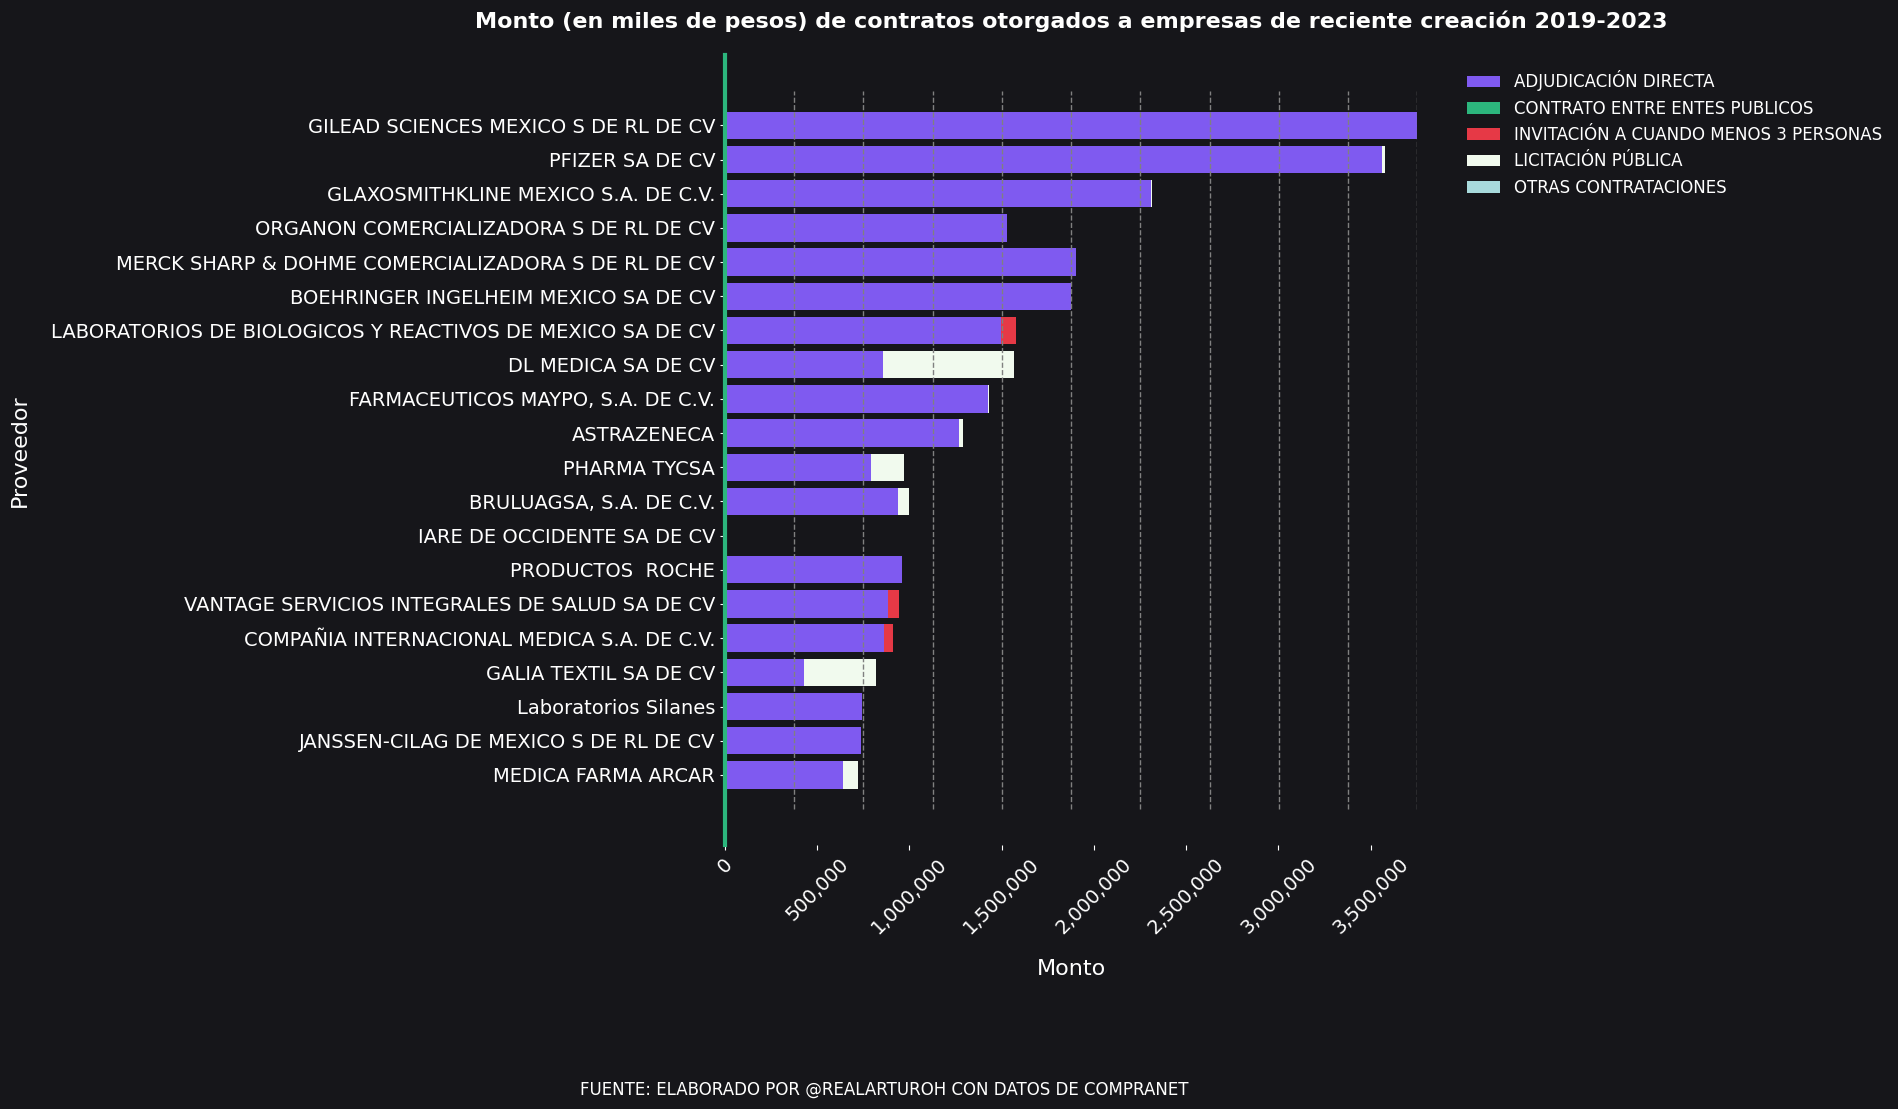

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

top20df = top_20_suspicious_providers_df.sort_values(by='importe', ascending=True)
top20df['importe'] = top20df['importe']/1000

# Datos
proveedores = top20df['proveedor_o_contratista'].tolist()
tipos_procedimiento = ['ADJUDICACIÓN DIRECTA', 'CONTRATO ENTRE ENTES PUBLICOS', 'INVITACIÓN A CUANDO MENOS 3 PERSONAS', 'LICITACIÓN PÚBLICA', 'OTRAS CONTRATACIONES', 'OTRO']

# Calcular los importes por tipo de procedimiento en función de los porcentajes y el importe total
colors = ['#7f5af0', '#2cb67d', '#e63946', '#f1faee', '#a8dadc', '#457b9d']

data_procedimientos = []
tipos_presentes = []
colores_presentes = []
for i, tipo in enumerate(tipos_procedimiento):
    if tipo in top20df.columns: # Verifica si el tipo de procedimiento existe en el DataFrame
        importe_tipo = (top20df[tipo] / 100) * top20df['importe']
        data_procedimientos.append(importe_tipo.values)
        tipos_presentes.append(tipo)
        colores_presentes.append(colors[i % len(colors)])


# Tamaño de la figura
height = max(10, 0.5 * len(proveedores))
width = height * (16/9)

fig, ax = plt.subplots(figsize=(width, height))

# Generar las barras apiladas
bars = []
for i, data in enumerate(data_procedimientos):
    bars.append(ax.barh(proveedores, data, left=[sum(data_procedimientos[j][k] for j in range(i)) for k in range(len(data))], color=colores_presentes[i]))


# Configuración del gráfico
ax.set_title(f"Monto (en miles de pesos) de contratos otorgados a empresas de reciente creación 2019-2023", fontsize=16, pad=20, fontweight='bold', color='#fffffe')



ax.set_ylabel("Proveedor", fontsize=16, labelpad=15, color='white')
ax.set_xlabel("Monto", fontsize=16, labelpad=15, color='white')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='x', labelsize=14, colors='white', rotation=45)
x_interval = (top20df['importe'].max() / 10)
for x in np.arange(0, top20df['importe'].max() + x_interval, x_interval):
    plt.vlines(x, ymin=-1, ymax=len(proveedores), colors='gray', linestyles='dashed', linewidth=1)
fig.set_facecolor('#16161a')
ax.set_facecolor('#16161a')
for spine in ['bottom', 'right', 'top']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_linewidth(3)
ax.spines['left'].set_color('#2cb67d')
ax.tick_params(axis='y', labelsize=14, colors='white')
legend = ax.legend(bars, tipos_presentes, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left') # Usa los tipos de procedimiento presentes
frame = legend.get_frame()
frame.set_alpha(0)
for text in legend.get_texts():
    text.set_color('white')
    
plt.figtext(0.5, -0.1, "FUENTE: ELABORADO POR @REALARTUROH CON DATOS DE COMPRANET", ha="center", fontsize=12, color='#fffffe')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15, right=0.8)
plt.show()
